In [59]:
import numpy as np
import copy
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

T = 2                           # total signal duration [s]
Nh = 2048                        # analysis window length [samples]
h = np.sqrt(np.hanning(Nh))     # analysis window  (perfect reconstruction constraint [COLA] is respected with root-Hann window) https://ccrma.stanford.edu/~jos/sasp/Choice_WOLA_Window.html
Nf = copy.copy(Nh)              # synthesis window length [samples]
f = np.sqrt(np.hanning(Nf))     # synthesis window  (perfect reconstruction constraint [COLA] is respected with root-Hann window) https://ccrma.stanford.edu/~jos/sasp/Choice_WOLA_Window.html
R = int(Nh * 0.5)              # window shift [samples]

# load signal
x, fs = sf.read('U:/py/sounds-phd/02_data/00_raw_signals/01_speech/speech1.wav')
x = x[:int(T * fs)]

# =========== WOLA =========== block-by-block DFTs
y = np.zeros_like(x)
ii = 0
while True:
    idxBeg = ii*R
    idxEnd = idxBeg + Nh
    if idxEnd > len(x):
        break
    xcurr = copy.copy(x[idxBeg:idxEnd])

    xcurr *= h  # synthesis window

    Xcurr = np.fft.fft(xcurr, Nh, axis=0)

    # spectral modifications
    Ycurr = copy.copy(Xcurr)   # <-- no modifications

    ycurr = np.fft.ifft(Ycurr, Nf, axis=0)
    ycurr = np.real_if_close(ycurr)
    ycurr *= f  # analysis window

    # y[idxBeg:idxEnd] += xcurr * f
    y[idxBeg:idxEnd] += ycurr

    ii += 1

# # =========== Filter bank ===========
# y_fb = np.zeros_like(x)
# for k in range(Nh):
#     print(f'Computing for freq. bin #{k+1}/{Nh}')
    
#     # Analysis
#     W = np.exp(1j * 2 * np.pi / Nh * (-k * np.arange(len(x))))
#     yk = sig.convolve(x * W, h)
#     yk = yk[:len(x)]

#     # Synthesis
#     xout = sig.convolve(yk, f)
#     xout = xout[:len(x)]
#     W = np.exp(1j * 2 * np.pi / Nh * (k * np.arange(len(x))))
#     xout *= W
#     xout = np.real_if_close(xout)
#     y_fb += xout

fig, axes = plt.subplots(2,1)
fig.set_size_inches(14.5, 6.5)
axes[0].plot(x, label='x')
axes[0].plot(y, '--', label='y')
axes[0].grid()
axes[0].legend()
axes[1].plot(y - x)
plt.tight_layout()	
plt.show()

Computing for freq. bin #1/2048


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

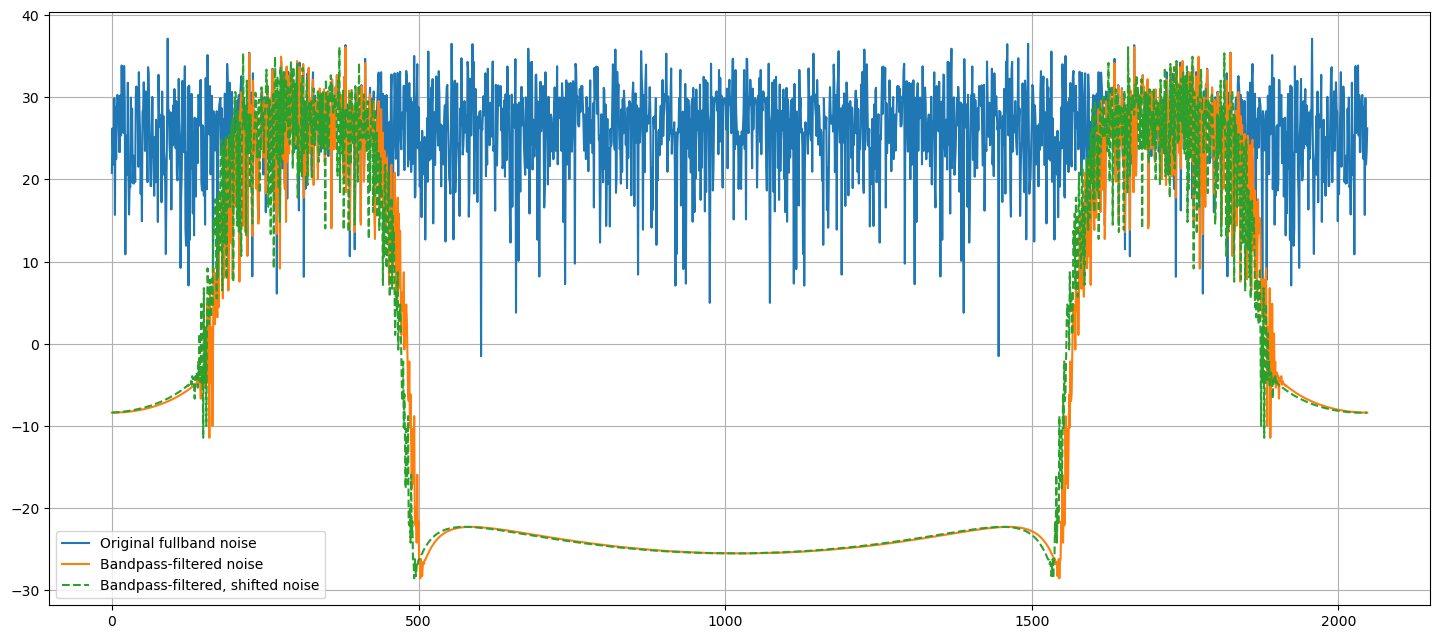

In [105]:
# --------- SEE WORD JOURNAL WEEK28 2022, WED --------
# Create bandpass noise
fs = 16000
T = 1
N = 2048
noise = 2 * np.random.random(T * fs) - 1
bpf = sig.firls(101, [0, 1e3, 2e3, 3e3, 4e3, 8e3], [0,0, 1, 1, 0, 0], fs=fs)
bpnoise = sig.fftconvolve(noise, bpf)

# Apply phase shift via complex exponential
bpnoiseshifted = bpnoise * np.exp(- 1j * 2 * np.pi / N * np.arange(len(bpnoise)) * 10)

Noise = np.fft.fft(noise, N)
BpNoise = np.fft.fft(bpnoise, N)
BpNoiseshifted = np.fft.fft(bpnoiseshifted, N)


fig, axes = plt.subplots(1,1)
fig.set_size_inches(14.5, 6.5)
axes.plot(20*np.log10(np.abs(Noise)), label='Original fullband noise')
axes.plot(20*np.log10(np.abs(BpNoise)), label='Bandpass-filtered noise')
axes.plot(20*np.log10(np.abs(BpNoiseshifted)), '--', label='Bandpass-filtered, shifted noise')
axes.grid()
axes.legend()
plt.tight_layout()	
plt.show()